<center><h1>Lyrics Generator</h1></center>

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk import pos_tag, word_tokenize
from autocorrect import Speller

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import LSTM, Dense
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

import spacy


In [2]:
import spacy.cli
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
nlp=spacy.load('en_core_web_lg')
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

## Constants

In [4]:
DATASET = "Songs.csv"
spell = Speller()

# Preprocessing

## Loading the Dataset

In [5]:
data = pd.read_csv("Songs.csv")
data.head()

Artist                     Title  \
0  Taylor Swift                  cardigan   
1  Taylor Swift                     exile   
2  Taylor Swift                     Lover   
3  Taylor Swift                     the 1   
4  Taylor Swift  Look What You Made Me Do   

                                              Lyrics  
0  Vintage tee, brand new phone\nHigh heels on co...  
1  I can see you standing, honey\nWith his arms a...  
2  We could leave the Christmas lights up 'til Ja...  
3  I'm doing good, I'm on some new shit\nBeen say...  
4  I don't like your little games\nDon't like you...

## Data Exploration

In [6]:
print("Artists in the data:\n",data.Artist.value_counts()) 

Artists in the data:
 Taylor Swift          50
David Bowie           50
Billy Joel            50
Eric Clapton          50
Billie Eilish         50
Leonard Cohen         50
Bruce Springsteen     40
The Beatles           35
Ray LaMontagne        30
Elton John            30
Queen                 30
Frank Sinatra         30
John Denver           30
Bryan Adams           30
​twenty one pilots    30
Nat King Cole         30
Lana Del Rey          30
Vance Joy             30
George Michael        30
Bob Dylan             20
Ed Sheeran            20
Name: Artist, dtype: int64


In [7]:
print("Size of Dataset:",data.shape)

Size of Dataset: (745, 3)


### Number of Characters vs Number of Words vs Number of Lines

In [8]:
data["No_of_Characters"] = data["Lyrics"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Lyrics"]), axis=1).apply(len)
data["No_of_Lines"] = data["Lyrics"].str.split('\n').apply(len)
data.describe()

No_of_Characters  No_of_Words  No_of_Lines
count        745.000000   745.000000   745.000000
mean        1403.347651   319.400000    46.277852
std          666.721467   156.163646    21.180531
min            1.000000     1.000000     1.000000
25%          946.000000   215.000000    33.000000
50%         1289.000000   291.000000    44.000000
75%         1714.000000   389.000000    56.000000
max         7267.000000  1652.000000   224.000000

### Comparative song lengths for various artists

<Figure size 1080x1080 with 0 Axes>

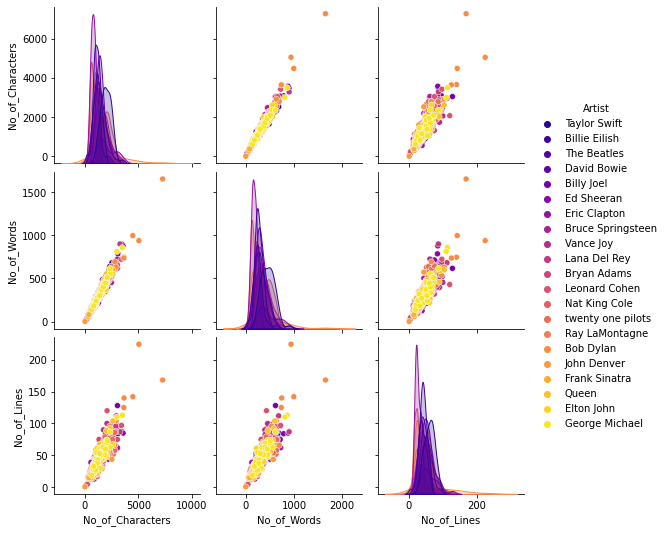

In [9]:
plt.figure(figsize=(15,15))
ax = sns.pairplot(data, hue="Artist", palette="plasma")

The generation of text with RNN involves the following workflow.  

<p style="background-color:#B3C5E3;font-family:newtimeroman;color:#444160;text-align:center;font-size:120%;">Loading Data ➡️ Preprocessing ➡️ Building Mapping Dictionary ➡️ Building Model ➡️ Generating Text</p>

As I have loaded and explored the data,  I will proceed further by pre-processing the text.  


<a id="4"></a>
# <p style="background-color:#B291B6;font-family:newtimeroman;color:#444160;font-size:150%;text-align:center;border-radius:20px 60px;">DATA PREPROCESSING</p>

**In this section, I will be performing the following:**

**Creating a Corpus of Lyrics text:** For the model, we need a sequence of the text string. I am creating a Corpus out of Lyrics column. 

**Removing the unrequired characters that may have sneaked in my text corpus:** The data cleaning process for NLP is crucial preprocessing. To do that, I look into the Corpus to check for what this Corpus is comprised of. That is, all the unique symbols present. After examining the Corpus, I will be eliminating any foreign language or irrelevant symbols from the Corpus. 

**Creating a dictionary to map characters and their indices:** The computer doesn’t understand the text. For the computer, the text is just a cluster of symbols. It works with numbers. So we create a dictionary to map each unique character in our Corpus to a number and vice versa. This will be used to encode and decode the information going in and getting out of the RNN

**Splitting the corpus into smaller sentences of equal length:** Encoding and splitting the corpus into smaller sequences of equal length: At this point, Corpus contain only intended characters (i.e, lower cap English alphabets, Numbers and a few punctuations). We will encode this corpus and create small sequences of equal lengths of features and the corresponding targets. Each feature and target will contain the mapped index in the dictionary of the unique characters they signify. 

The labels are then resized and normalized. Whereas the targets are one-hot encoded. Ready to be sent to the RNN for the training, but before that let us built the RNN model. 

**Creating a Corpus**

In [10]:
#Lining up all the lyrics to create corpus
Corpus =''
List_Corpus = []
for listitem in data.Lyrics:
    Corpus += listitem
    List_Corpus.append(word_tokenize(listitem))
    
Corpus = Corpus.lower() #converting all alphabets to lowecase 
print("Number of unique characters:", len(set(Corpus)))
List_Corpus

Number of unique characters: 92


[['Vintage',
  'tee',
  ',',
  'brand',
  'new',
  'phone',
  'High',
  'heels',
  'on',
  'cobblestones',
  'When',
  'you',
  'are',
  'young',
  ',',
  'they',
  'assume',
  'you',
  'know',
  'nothing',
  'Sequin',
  'smile',
  ',',
  'black',
  'lipstick',
  'Sensual',
  'politics',
  'When',
  'you',
  'are',
  'young',
  ',',
  'they',
  'assume',
  'you',
  'know',
  'nothing',
  'But',
  'I',
  'knew',
  'you',
  'Dancin',
  "'",
  'in',
  'your',
  "Levi's",
  'Drunk',
  'under',
  'a',
  'streetlight',
  ',',
  'I',
  'I',
  'knew',
  'you',
  'Hand',
  'under',
  'my',
  'sweatshirt',
  'Baby',
  ',',
  'kiss',
  'it',
  'better',
  ',',
  'I',
  'And',
  'when',
  'I',
  'felt',
  'like',
  'I',
  'was',
  'an',
  'old',
  'cardigan',
  'Under',
  'someone',
  "'s",
  'bed',
  'You',
  'put',
  'me',
  'on',
  'and',
  'said',
  'I',
  'was',
  'your',
  'favorite',
  'A',
  'friend',
  'to',
  'all',
  'is',
  'a',
  'friend',
  'to',
  'none',
  'Chase',
  'two',
  'girl

In [11]:
tagged_corpus = [pos_tag(sent) for sent in List_Corpus]
tagged_corpus

[[('Vintage', 'NNP'),
  ('tee', 'NN'),
  (',', ','),
  ('brand', 'NN'),
  ('new', 'JJ'),
  ('phone', 'NN'),
  ('High', 'NNP'),
  ('heels', 'NNS'),
  ('on', 'IN'),
  ('cobblestones', 'NNS'),
  ('When', 'WRB'),
  ('you', 'PRP'),
  ('are', 'VBP'),
  ('young', 'JJ'),
  (',', ','),
  ('they', 'PRP'),
  ('assume', 'VBP'),
  ('you', 'PRP'),
  ('know', 'VBP'),
  ('nothing', 'NN'),
  ('Sequin', 'NNP'),
  ('smile', 'NN'),
  (',', ','),
  ('black', 'JJ'),
  ('lipstick', 'JJ'),
  ('Sensual', 'NNP'),
  ('politics', 'NNS'),
  ('When', 'WRB'),
  ('you', 'PRP'),
  ('are', 'VBP'),
  ('young', 'JJ'),
  (',', ','),
  ('they', 'PRP'),
  ('assume', 'VBP'),
  ('you', 'PRP'),
  ('know', 'VBP'),
  ('nothing', 'NN'),
  ('But', 'CC'),
  ('I', 'PRP'),
  ('knew', 'VBD'),
  ('you', 'PRP'),
  ('Dancin', 'NNP'),
  ("'", "''"),
  ('in', 'IN'),
  ('your', 'PRP$'),
  ("Levi's", 'NNP'),
  ('Drunk', 'NNP'),
  ('under', 'IN'),
  ('a', 'DT'),
  ('streetlight', 'NN'),
  (',', ','),
  ('I', 'PRP'),
  ('I', 'PRP'),
  ('knew',

The total number of unique characters present in the Corpus clearly shows, that some of the foreign language scripts have sneaked in. I will take a look at all the characters present. I will then remove the unrequired characters. 

## Named Entities Recognition

In [12]:
#To See all the unique characters present in the Corpus
print("The unique characters:",sorted(set(Corpus)))

The unique characters: ['\n', ' ', '!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '>', '?', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '~', '©', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ó', 'ö', 'ü', 'ŏ', 'е', 'ا', 'س', 'ل', 'م', 'و', '\u2005', '\u200a', '\u200b', '–', '—', '‘', '’', '‚', '“', '”', '…', '\u205f', '\ufeff']


In [13]:
#Keeping only a limited set of characters. 
to_remove = ['{', '}', '~', '©', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ó', 'ö', 'ü', 'ŏ',
             'е', 'ا', 'س', 'ل', 'م', 'و', '\u2005', '\u200a', '\u200b', '–', '—', '‘', '’', '‚', '“', '”', 
             '…', '\u205f', '\ufeff', '!', '&', '(', ')', '*', '-',  '/', ]
for symbol in to_remove:
    Corpus = Corpus.replace(symbol," ")

#Corpus = re.sub("[^A-Za-z0-9'\.\n]","",Corpus) Alterneativly could be used but I want to pick and chose (:

In [14]:
#To See all the unique characters present in the Corpus
print("The unique characters:",sorted(set(Corpus)))

The unique characters: ['\n', ' ', '"', "'", ',', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '>', '?', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


**Creating a list of sorted unique characters**

In [15]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

reverse_mapping

Total number of characters: 1045494
Number of unique characters: 47


{0: '\n',
 1: ' ',
 2: '"',
 3: "'",
 4: ',',
 5: '.',
 6: '0',
 7: '1',
 8: '2',
 9: '3',
 10: '4',
 11: '5',
 12: '6',
 13: '7',
 14: '8',
 15: '9',
 16: ':',
 17: ';',
 18: '>',
 19: '?',
 20: '`',
 21: 'a',
 22: 'b',
 23: 'c',
 24: 'd',
 25: 'e',
 26: 'f',
 27: 'g',
 28: 'h',
 29: 'i',
 30: 'j',
 31: 'k',
 32: 'l',
 33: 'm',
 34: 'n',
 35: 'o',
 36: 'p',
 37: 'q',
 38: 'r',
 39: 's',
 40: 't',
 41: 'u',
 42: 'v',
 43: 'w',
 44: 'x',
 45: 'y',
 46: 'z'}

In [16]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)
print("Features: ", len(features))
print("Targets: ", len(targets))


Total number of sequences in the Corpus: 1045454
Features:  1045454
Targets:  1045454


**Encoding the Labels and Targets**

In [17]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)

# one hot encode the output variable
y = np_utils.to_categorical(targets)

<a id="5"></a>
# <p style="background-color:#B291B6;font-family:newtimeroman;font-size:150%;color:#444160;text-align:center;border-radius:20px 60px;">MODEL BUILDING</p>


Recurrent Neural Networks are pretty popular with generating text. In this project, I will be using a LSTM Model, an improved version of a standard recurrent neural network

**Following steps are involved in the model building**

* Initialising the Model
* Defining by adding layers
* Compiling the Model
* Training the Model

**Building the Model**

In [18]:
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='softmax'))
opt = tf.keras.optimizers.Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense (Dense)               (None, 47)                12079     
                                                                 
Total params: 276,271
Trainable params: 276,271
Non-trainable params: 0
_________________________________________________________________


In [19]:
#Training the Model
history = model.fit(X, y, batch_size=128, epochs=100)

Epoch 1/100


In [ ]:
from keras.models import load_model
#To be used later; I am saving the model 
model.save("Lyrics_Generator.h5")

<a id="6"></a>
# <p style="background-color:#B291B6;font-family:newtimeroman;font-size:150%;color:#444160;text-align:center;border-radius:20px 60px;">EVALUATING MODELS</p>

Now that I have my model trained on the songs lyrics let us see how it performs. I hope it creates some sensible song.

**To evaluate my model, I shall be having a look at:**
* The performance of the model via Learning Curves
* The outcome text it generates

**Plotting the learning curve for the loss function**

In [ ]:
history_df = pd.DataFrame(history.history)
#Plotting the learnings 

fig = plt.figure(figsize=(15,4), facecolor="#B291B6")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

NameError: name 'history' is not defined

## Loading the Model from a file

In [ ]:
model.load_weights("Lyrics_Generator_kaggle_v2.h5")

## Generating the Song

In [ ]:
# The function to generate text from model
def Lyrics_Generator(starter,Ch_count): #,temperature=1.0):
    generated= ""
    starter = starter 
    seed=[mapping[char] for char in starter]
    generated += starter 
    # Generating new text of given length
    for i in range(Ch_count):
        seed=[mapping[char] for char in starter]
        x_pred = np.reshape(seed, (1, len(seed), 1))
        x_pred = x_pred/ float(L_symb)
        prediction = model.predict(x_pred, verbose=0)[0]  
        # Getting the index of the next most probable index
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / 1.0 
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        # probas = np.random.multinomial(1, prediction, 1)
        index = np.argmax(prediction)
        next_char = reverse_mapping[index]
        # Generating new text
        generated += next_char
        starter = starter[1:] + next_char
       
    return generated

Let us finally see the outcome by putting a seed in from one of my old blogposts [blogpost](https://karnikakapoor.blogspot.com/2017/04/killers-confession.html)

In [ ]:
#Generating a song from the model
song_1 = Lyrics_Generator("the shoe shrunk, and the school belt got ridiculously", 400)
#Let's have a look at the song
print(song_1)

the shoe shrunk, and the school belt got ridiculously
i want to be porting to me

i want to be part of the light
i wanna be your andais 
and i was blrnilglg to me

i wanna be your andraciu, i gave you 
the world is gor the ramntarnd
the share of the stars that i was blun
i think it's gonna be a long  ooh awa
to take mem

there is no stome to the ooly thmng that i was a ster
the stars that we hete and the wieel
the stars they could the thene the same


Another song generated by a seed of the lyrics of a song that's stuck in my head today. (Sunflower by Shannon Purser)

In [ ]:
#Generating a song from the model using a song out of the corpus
song_2 = Lyrics_Generator("i'm a sunflower, a little funny", 400)
#Let's have a look at the song
print(spell(song_2))

i'm a sunflower, a little funny did 
i was burning by, i want to be a better ar the dark
i hot to meet about the ramp
ole foo the world
where we cre the same
the way that i would ts the food
would you be wat, you are the one

i'm so high, i'm a brook of my ears astute
i don't know why it is not show
it it would you be a batting and the rules
of a better broke for a star
i was blind to the blogs
i was blind the barrels the way



In [ ]:
song_3 = Lyrics_Generator("only need a light, when its burning low", 400)

print(spell(song_3))

only need a light, when its burning lowe
i was blind the world
i was blind the world
i was blind the world
i was blind the world
i was blind the world
i was blind the world
i was blind the world
i was blind the world
i was blind the world
i was blind the world
i was blind the world
i was blind the world
i was blind the world
i was blind the world
i was blind the world
i was blind the world
i was blind the world
i was blind the world
i 


In [ ]:
song_3 = Lyrics_Generator("", 400)

print(spell(song_3))